In [1]:
import numpy as np
import pandas as pd
from scipy.stats import chi2_contingency
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as stats
import matplotlib.pyplot as plt

# Load Data

In [2]:
df_data = pd.read_csv('data/exercise_data.csv', sep=',')

In [3]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1100 entries, 0 to 1099
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Chromosome  1100 non-null   object
 1   Position    1100 non-null   int64 
 2   Sample1 A   1100 non-null   int64 
 3   Sample1 B   1100 non-null   int64 
 4   Sample2 A   1100 non-null   int64 
 5   Sample2 B   1100 non-null   int64 
 6   Sample3 A   1100 non-null   int64 
 7   Sample3 B   1100 non-null   int64 
 8   Sample4 A   1100 non-null   int64 
 9   Sample4 B   1100 non-null   int64 
 10  Sample5 A   1100 non-null   int64 
 11  Sample5 B   1100 non-null   int64 
 12  Sample6 A   1100 non-null   int64 
 13  Sample6 B   1100 non-null   int64 
dtypes: int64(13), object(1)
memory usage: 120.4+ KB


In [4]:
df_data

,Chromosome,Position,Sample1 A,Sample1 B,Sample2 A,Sample2 B,Sample3 A,Sample3 B,Sample4 A,Sample4 B,Sample5 A,Sample5 B,Sample6 A,Sample6 B
0,chra,6,0,17,10,17,2,30,19,0,1,0,13,9
1,chra,167,10,10,8,14,15,16,2,15,14,2,6,0
2,chra,249,19,1,10,16,8,0,1,0,9,0,18,8
3,chra,288,10,9,13,0,0,20,7,15,8,0,8,12
4,chra,329,13,15,0,1,3,11,4,18,18,4,6,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1095,chrk,9680,4,7,16,16,8,0,6,14,3,3,11,11
1096,chrk,9701,13,4,1,0,5,28,15,5,15,13,4,16
1097,chrk,9703,1,22,11,1,12,6,8,13,3,16,1,8
1098,chrk,9837,16,5,1,14,14,1,20,15,8,14,34,4


# Problem Description

In the genome of a newly discovered alien is a modification named “A” and “B”. This effects certain positions of the genome and where it does only modification of “A” and “B” can exist. e.g. At each position, a sample can have only A modification, only B modification or a mixture of the two. This modification seems to change depending on where in the planet the aliens lived. There are 2 distinct regions, north and south.

To investigate this an experiment was run, to analyse aliens from the north and south of the planet. Three samples (Samples 1-3) were collected from the north part and three samples (Samples 4-6) were collected from the south part. The data collected was the counts of “A” modification and “B” modifications at each position in the alien genome and is found in the “exercise_data.csv” file attached.

**Question: Determine the positions in the genome which define the north vs south aliens?**

## Notes

This is a problem of feature selection. We need to determine whether the classification of an alien being is dependant or independent of each position in the genome given the data about the genome modifications A and B. 

Given the information in the example, at each position listed, there are only two alleles - **A** and **B**. At each position there can be multiple instances of **dd/dD/DD** where **d** is the minor allele and **D** the major allele. Given that we do not have a reference genome for this organism, we must classify major/minor allele at each position based on allele frequency. 

The source data contains the allele counts for **A** and **B** in each sample and each position - given the dependant variable is categorical (North/South), we can therefore perform basic allele testing with the Chi-squared test at each position to obtain a p-value of independence. This can then be thresholded using a Bonferroni corrected p-value to obtain positions that have a statistically significant level of contribution to the dependant variable (North/South)

In statistical genetics this type of study is known as a **genome-wide association study (GWAS)**

# Processing

### Sum allele counts for each category and calculate the allele frquencies

In [5]:
a_samples = ['Sample1 A', 'Sample2 A', 'Sample3 A', 'Sample4 A', 'Sample5 A', 'Sample6 A']
b_samples = ['Sample1 B', 'Sample2 B', 'Sample3 B', 'Sample4 B', 'Sample5 B', 'Sample6 B']

north_a_samples = ['Sample1 A', 'Sample2 A', 'Sample3 A']
north_b_samples = ['Sample1 B', 'Sample2 B', 'Sample3 B']
south_a_samples = ['Sample4 A', 'Sample5 A', 'Sample6 A']
south_b_samples = ['Sample4 B', 'Sample5 B', 'Sample6 B']

In [6]:
df_data['a_sum'] = df_data[a_samples].sum(axis=1)
df_data['b_sum'] = df_data[b_samples].sum(axis=1)
df_data['north_a_sum'] = df_data[north_a_samples].sum(axis=1)
df_data['north_b_sum'] = df_data[north_b_samples].sum(axis=1)
df_data['south_a_sum'] = df_data[south_a_samples].sum(axis=1)
df_data['south_b_sum'] = df_data[south_b_samples].sum(axis=1)

df_data['total_sum'] = df_data['a_sum'] + df_data['b_sum']
df_data['a_allele_freq'] = df_data['a_sum'] / df_data['total_sum']
df_data['b_allele_freq'] = df_data['b_sum'] / df_data['total_sum']

In [7]:
df_data

,Chromosome,Position,Sample1 A,Sample1 B,Sample2 A,Sample2 B,Sample3 A,Sample3 B,Sample4 A,Sample4 B,...,Sample6 B,a_sum,b_sum,north_a_sum,north_b_sum,south_a_sum,south_b_sum,total_sum,a_allele_freq,b_allele_freq
0,chra,6,0,17,10,17,2,30,19,0,...,9,45,73,12,64,33,9,118,0.381356,0.618644
1,chra,167,10,10,8,14,15,16,2,15,...,0,55,57,33,40,22,17,112,0.491071,0.508929
2,chra,249,19,1,10,16,8,0,1,0,...,8,65,25,37,17,28,8,90,0.722222,0.277778
3,chra,288,10,9,13,0,0,20,7,15,...,12,46,56,23,29,23,27,102,0.450980,0.549020
4,chra,329,13,15,0,1,3,11,4,18,...,12,44,61,16,27,28,34,105,0.419048,0.580952
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1095,chrk,9680,4,7,16,16,8,0,6,14,...,11,48,51,28,23,20,28,99,0.484848,0.515152
1096,chrk,9701,13,4,1,0,5,28,15,5,...,16,53,66,19,32,34,34,119,0.445378,0.554622
1097,chrk,9703,1,22,11,1,12,6,8,13,...,8,36,66,24,29,12,37,102,0.352941,0.647059
1098,chrk,9837,16,5,1,14,14,1,20,15,...,4,93,53,31,20,62,33,146,0.636986,0.363014


### Create basic allele test columns

In [8]:
df_data['north_d'] = np.where(df_data.a_allele_freq >= df_data.b_allele_freq, df_data.north_b_sum, df_data.north_a_sum)
df_data['north_D'] = np.where(df_data.a_allele_freq >= df_data.b_allele_freq, df_data.north_a_sum, df_data.north_b_sum)
df_data['south_d'] = np.where(df_data.a_allele_freq >= df_data.b_allele_freq, df_data.south_b_sum, df_data.south_a_sum)
df_data['south_D'] = np.where(df_data.a_allele_freq >= df_data.b_allele_freq, df_data.south_a_sum, df_data.south_b_sum)

df_data

,Chromosome,Position,Sample1 A,Sample1 B,Sample2 A,Sample2 B,Sample3 A,Sample3 B,Sample4 A,Sample4 B,...,north_b_sum,south_a_sum,south_b_sum,total_sum,a_allele_freq,b_allele_freq,north_d,north_D,south_d,south_D
0,chra,6,0,17,10,17,2,30,19,0,...,64,33,9,118,0.381356,0.618644,12,64,33,9
1,chra,167,10,10,8,14,15,16,2,15,...,40,22,17,112,0.491071,0.508929,33,40,22,17
2,chra,249,19,1,10,16,8,0,1,0,...,17,28,8,90,0.722222,0.277778,17,37,8,28
3,chra,288,10,9,13,0,0,20,7,15,...,29,23,27,102,0.450980,0.549020,23,29,23,27
4,chra,329,13,15,0,1,3,11,4,18,...,27,28,34,105,0.419048,0.580952,16,27,28,34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1095,chrk,9680,4,7,16,16,8,0,6,14,...,23,20,28,99,0.484848,0.515152,28,23,20,28
1096,chrk,9701,13,4,1,0,5,28,15,5,...,32,34,34,119,0.445378,0.554622,19,32,34,34
1097,chrk,9703,1,22,11,1,12,6,8,13,...,29,12,37,102,0.352941,0.647059,24,29,12,37
1098,chrk,9837,16,5,1,14,14,1,20,15,...,20,62,33,146,0.636986,0.363014,20,31,33,62


### Create contigency tables based on the basical allele test model shown in an example below

In [9]:
a = np.zeros(shape=(2,2), dtype=int)
df_cont_ex = pd.DataFrame(a,columns=['north', 'south'], index=['d', 'D'])
df_cont_ex

,north,south
d,0,0
D,0,0


In [10]:
df_data["contingency"] = df_data.apply(lambda x: np.array([[x.north_d, x.south_d], [x.north_D, x.south_D]]), axis=1)
df_data

,Chromosome,Position,Sample1 A,Sample1 B,Sample2 A,Sample2 B,Sample3 A,Sample3 B,Sample4 A,Sample4 B,...,south_a_sum,south_b_sum,total_sum,a_allele_freq,b_allele_freq,north_d,north_D,south_d,south_D,contingency
0,chra,6,0,17,10,17,2,30,19,0,...,33,9,118,0.381356,0.618644,12,64,33,9,"[[12, 33], [64, 9]]"
1,chra,167,10,10,8,14,15,16,2,15,...,22,17,112,0.491071,0.508929,33,40,22,17,"[[33, 22], [40, 17]]"
2,chra,249,19,1,10,16,8,0,1,0,...,28,8,90,0.722222,0.277778,17,37,8,28,"[[17, 8], [37, 28]]"
3,chra,288,10,9,13,0,0,20,7,15,...,23,27,102,0.450980,0.549020,23,29,23,27,"[[23, 23], [29, 27]]"
4,chra,329,13,15,0,1,3,11,4,18,...,28,34,105,0.419048,0.580952,16,27,28,34,"[[16, 28], [27, 34]]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1095,chrk,9680,4,7,16,16,8,0,6,14,...,20,28,99,0.484848,0.515152,28,23,20,28,"[[28, 20], [23, 28]]"
1096,chrk,9701,13,4,1,0,5,28,15,5,...,34,34,119,0.445378,0.554622,19,32,34,34,"[[19, 34], [32, 34]]"
1097,chrk,9703,1,22,11,1,12,6,8,13,...,12,37,102,0.352941,0.647059,24,29,12,37,"[[24, 12], [29, 37]]"
1098,chrk,9837,16,5,1,14,14,1,20,15,...,62,33,146,0.636986,0.363014,20,31,33,62,"[[20, 33], [31, 62]]"


### Perform chi-squared test on each table

In [11]:
def chi2(s):
    chi2, p, dof, ex = chi2_contingency(s)
    return chi2, p

In [12]:
df_data['chi2'], df_data['p'] = zip(*df_data['contingency'].apply(chi2))
df_data

,Chromosome,Position,Sample1 A,Sample1 B,Sample2 A,Sample2 B,Sample3 A,Sample3 B,Sample4 A,Sample4 B,...,total_sum,a_allele_freq,b_allele_freq,north_d,north_D,south_d,south_D,contingency,chi2,p
0,chra,6,0,17,10,17,2,30,19,0,...,118,0.381356,0.618644,12,64,33,9,"[[12, 33], [64, 9]]",42.571893,6.813140e-11
1,chra,167,10,10,8,14,15,16,2,15,...,112,0.491071,0.508929,33,40,22,17,"[[33, 22], [40, 17]]",0.867970,3.515180e-01
2,chra,249,19,1,10,16,8,0,1,0,...,90,0.722222,0.277778,17,37,8,28,"[[17, 8], [37, 28]]",0.519231,4.711700e-01
3,chra,288,10,9,13,0,0,20,7,15,...,102,0.450980,0.549020,23,29,23,27,"[[23, 23], [29, 27]]",0.000381,9.844324e-01
4,chra,329,13,15,0,1,3,11,4,18,...,105,0.419048,0.580952,16,27,28,34,"[[16, 28], [27, 34]]",0.373309,5.412063e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1095,chrk,9680,4,7,16,16,8,0,6,14,...,99,0.484848,0.515152,28,23,20,28,"[[28, 20], [23, 28]]",1.244793,2.645494e-01
1096,chrk,9701,13,4,1,0,5,28,15,5,...,119,0.445378,0.554622,19,32,34,34,"[[19, 34], [32, 34]]",1.435195,2.309185e-01
1097,chrk,9703,1,22,11,1,12,6,8,13,...,102,0.352941,0.647059,24,29,12,37,"[[24, 12], [29, 37]]",3.952751,4.679480e-02
1098,chrk,9837,16,5,1,14,14,1,20,15,...,146,0.636986,0.363014,20,31,33,62,"[[20, 33], [31, 62]]",0.126773,7.218021e-01


### Calculate bonferroni corrected p-value thresholds

In [13]:
num_tests = len(df_data['Chromosome'])

threshold_005 = -np.log10(0.05 / num_tests)
threshold_001 = -np.log10(0.01 / num_tests)
threshold_gwas = -np.log10(0.00000005) # 5x10-8

print('-logP threshold               = ', str(threshold_005))
print('-logP conservative threshold  = ', str(threshold_001))
print('-logP standard gwas threshold = ', str(threshold_gwas))

-logP threshold               =  4.342422680822207
-logP conservative threshold  =  5.041392685158225
-logP standard gwas threshold =  7.301029995663981


# Results and QC

### Create columns for plotting

In [14]:
df_data['-logp'] = -np.log10(df_data.p)
df_data.reset_index(inplace=True, drop=True)
df_data['i'] = df_data.index
df_data

,Chromosome,Position,Sample1 A,Sample1 B,Sample2 A,Sample2 B,Sample3 A,Sample3 B,Sample4 A,Sample4 B,...,b_allele_freq,north_d,north_D,south_d,south_D,contingency,chi2,p,-logp,i
0,chra,6,0,17,10,17,2,30,19,0,...,0.618644,12,64,33,9,"[[12, 33], [64, 9]]",42.571893,6.813140e-11,10.166653,0
1,chra,167,10,10,8,14,15,16,2,15,...,0.508929,33,40,22,17,"[[33, 22], [40, 17]]",0.867970,3.515180e-01,0.454052,1
2,chra,249,19,1,10,16,8,0,1,0,...,0.277778,17,37,8,28,"[[17, 8], [37, 28]]",0.519231,4.711700e-01,0.326822,2
3,chra,288,10,9,13,0,0,20,7,15,...,0.549020,23,29,23,27,"[[23, 23], [29, 27]]",0.000381,9.844324e-01,0.006814,3
4,chra,329,13,15,0,1,3,11,4,18,...,0.580952,16,27,28,34,"[[16, 28], [27, 34]]",0.373309,5.412063e-01,0.266637,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1095,chrk,9680,4,7,16,16,8,0,6,14,...,0.515152,28,23,20,28,"[[28, 20], [23, 28]]",1.244793,2.645494e-01,0.577493,1095
1096,chrk,9701,13,4,1,0,5,28,15,5,...,0.554622,19,32,34,34,"[[19, 34], [32, 34]]",1.435195,2.309185e-01,0.636541,1096
1097,chrk,9703,1,22,11,1,12,6,8,13,...,0.647059,24,29,12,37,"[[24, 12], [29, 37]]",3.952751,4.679480e-02,1.329802,1097
1098,chrk,9837,16,5,1,14,14,1,20,15,...,0.363014,20,31,33,62,"[[20, 33], [31, 62]]",0.126773,7.218021e-01,0.141582,1098


### Create table of positions which pass the threshold value

In [15]:
df_sig = df_data.loc[df_data['-logp'] >= threshold_005]
df_sig = df_sig[['Chromosome', 'Position', 'a_allele_freq', 'b_allele_freq', 'chi2', 'p', '-logp']]

print('Number of significant positions = ', str(len(df_sig)))

Number of significant positions =  150


In [16]:
df_sig = df_sig.sort_values(by='-logp', ascending=False)
df_sig.reset_index(inplace=True, drop=True)
df_sig

,Chromosome,Position,a_allele_freq,b_allele_freq,chi2,p,-logp
0,chrg,3441,0.500000,0.500000,71.216624,3.200798e-17,16.494742
1,chrh,8581,0.471429,0.528571,70.038312,5.816375e-17,16.235348
2,chri,7549,0.532258,0.467742,61.008828,5.681945e-15,14.245503
3,chrh,9716,0.659722,0.340278,51.894170,5.857408e-13,12.232295
4,chrd,7929,0.686957,0.313043,51.669329,6.568082e-13,12.182561
...,...,...,...,...,...,...,...
145,chrd,3778,0.289655,0.710345,16.872772,3.997087e-05,4.398256
146,chrd,3366,0.642276,0.357724,16.773979,4.210677e-05,4.375648
147,chra,9277,0.751825,0.248175,16.771421,4.216356e-05,4.375063
148,chri,2887,0.703390,0.296610,16.732171,4.304485e-05,4.366079


In [17]:
top_var = df_sig.loc[0]
print ('Lead variant is ' + str(top_var.Chromosome) + ':' + str(top_var.Position) + ' | -log-p = ' + str(top_var['-logp']))

Lead variant is chrg:3441 | -log-p = 16.494741665864762


### Generate manhattan plot

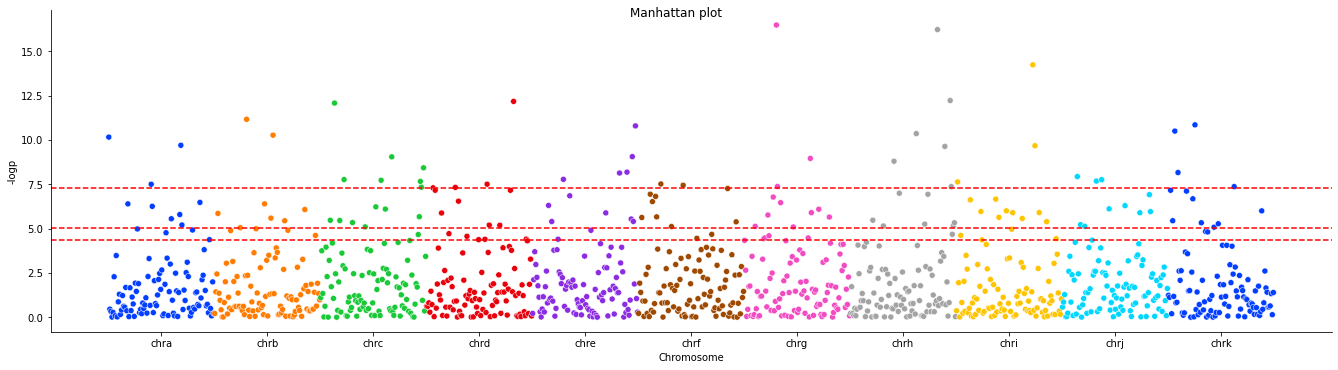

In [20]:
plot = sns.relplot(data=df_data, x='i', y='-logp', aspect=3.7, hue='Chromosome', palette = 'bright', legend=None)

chrom_df=df_data.groupby('Chromosome')['i'].median()
plot.ax.set_xlabel('Chromosome')
plot.ax.set_xticks(chrom_df);
plot.ax.set_xticklabels(chrom_df.index)
plot.fig.suptitle('Manhattan plot')

axis = plot.axes[0][0].axhline(threshold_005, ls='--', color='red')
# plot.axes[0][0].axhline(threshold_001, ls='--', color='red')
# plot.axes[0][0].axhline(threshold_gwas, ls='--', color='red')

### Generate QQ plot

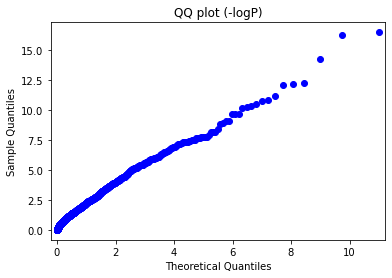

In [19]:
# Plot against chi2 dist with 1 degree of freedom
pplot = sm.ProbPlot(df_data['-logp'], stats.chi2, distargs=(1,))

# Format the chart
fig = pplot.qqplot()
h = plt.title("QQ plot (-logP)")